In [1]:
from gala import evaluate as ev, imio, viz
import numpy as np
from skimage.util import regular_seeds
from skimage import morphology as morph
from matplotlib import pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage import measure
import glob
import os
from os import path
import pprint
import re
import shutil
import sys
from functools import wraps, lru_cache
import numba

In [2]:
raw, gt = imio.read_cremi("../research_project_files/Cremi_Data/sample_B_20160501.hdf", datasets=['volumes/raw', 'volumes/labels/neuron_ids'])

In [4]:
raw = np.max(raw) - raw
raw = raw[raw.shape[0]//2]
gt = gt[gt.shape[0]//2]
gt_2d = measure.label(gt)
seeds = regular_seeds(raw.shape, np.random.randint(800, 1500))
automated_seg = morph.watershed(raw, seeds, compactness=0.001)


In [171]:
abs_path = path.abspath('../')
full_path = path.join(abs_path, 'research_project_files/Cremi_Data')
samples = [glob.iglob('*.hdf') for _,_,file in os.walk(full_path)]
my_files = [str(file).strip("/'") for file in os.listdir(full_path)]

SyntaxError: 'yield' outside function (<ipython-input-171-229518bdb592>, line 6)

In [4]:
automated_colorised = plt.cm.viridis(automated_seg)
automated_colorised[...,3] = 0.3

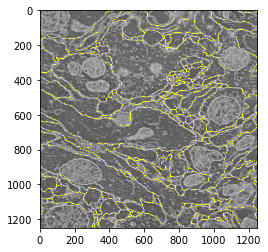

In [13]:
%matplotlib inline
fig2, ax2 = plt.subplots(ncols=1, nrows=1)
ax2.imshow(automated_seg, alpha=0.4)
viz.imshow_rand(mark_boundaries(raw, gt), axis=ax2)

In [6]:
%matplotlib auto
view_merges(gt, automated_seg)

Using matplotlib backend: Qt5Agg


In [40]:
plt.rcParams['font.size'] = 8
def view_all(gt, automated_seg, num_elem=4):
        """Generates a click-able image of the auto seg - upon click of
        the auto seg, shows the largest comps of the gt that corresponds
        to the worst false merges made in the automatic seg at the approx.
        same location of the click.
        Parameters
        gt: nd-array with shape M*N.
            This corresponds to the 'ground truth'.
        auto: nd-array with same shape as gt. This
            corresponds to the automated segmentation.
        num_elem: Int, optional.
            This parameter determines the number of comps
            shown upon click. Set to output '4' by default.
        returns:
        A panel with four images - the bottom right corresponds to the
        components that are the worst false merges in the automated
        segmentation that corresponds to the components clicked in
        the first window.
        """
        %matplotlib auto
        if gt.shape != automated_seg.shape:
            return "Input arrays are not of the same shape."
        elif (type(gt) or type(automated_seg)) != np.ndarray:
            return "Input arrays not of valid type."
        cont = ev.contingency_table(automated_seg, gt)
        ii2, err2 = ev.sorted_vi_components(automated_seg, gt)[2:4]
        idxs = np.argsort(ii2)
        err_unsorted = err2[idxs]
        err_img = err_unsorted[automated_seg]
        plt.interactive = False
        fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(9,9))
        plt.setp(ax.flat, aspect=1.0, adjustable='box-forced')
        ax[0, 0].imshow(raw, cmap='gray')
        viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0, 0])
        ax[0, 1].imshow(raw, cmap='gray')
        axes_image_1 = viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0, 1])
        ax[1, 0].imshow(raw, cmap='gray')
        viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 0])
        ax[1, 1].imshow(raw, cmap='gray')
        axes_image = viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 1])
        ax[0, 0].set_title("Automated seg: click to show worst splits.")
        ax[0, 1].set_title("Worst merge comps in gt, colored by VI error.")
        ax[1, 0].set_title("Ground truth with random cm: click to show worst merges.")
        ax[1, 1].set_title("Worst split comps in the gt, colored by VI error.")

        def _onpress(event):
            if event.inaxes == ax[1, 0]:
                if event.button != 1:
                    return
                x, y = int(event.xdata), int(event.ydata)
                comps = ev.split_components(gt[y, x], cont, axis=1, num_elems=None)
                new_seg = np.zeros_like(automated_seg)
                factor = (automated_seg.max() // num_elem)
                lim = 0.0
                for i, (j, k, z) in enumerate(comps):
                    lim += k
                    if z < 0.02:
                        continue
                    new_seg += (automated_seg == j) * ((i + 1) * factor)
                    if lim >= 0.95:
                        break
                axes_image.set_array(new_seg)
                fig.canvas.draw()
            elif event.inaxes == ax[0, 0]:
                if event.button != 1:
                    return
                x, y = int(event.xdata), int(event.ydata)
                comps = ev.split_components(automated_seg[y, x], cont, axis=0, num_elems=num_elem)
                new_seg = np.zeros_like(gt.astype('float64'))
                factor = (gt.max() // num_elem)
                lim = 0.0
                for i, (j, k, z) in enumerate(comps):
                    lim +=k
                    if z < 0.02:
                        continue
                    new_seg += (gt == j) * ((i + 1) * factor)
                axes_image_1.set_array(new_seg)
                fig.canvas.draw()
            
        fig.canvas.mpl_connect('button_press_event', _onpress)
        plt.ioff()
        plt.show()

In [41]:
%matplotlib auto
view_all(gt, automated_seg)

Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg


In [14]:
plt.rcParams['font.size'] = 8
def view_all_1(gt, automated_seg, num_elem=4, axis=None):
        """Generates a click-able image of the auto seg - upon click of
        the auto seg, shows the largest comps of the gt that corresponds
        to the worst false merges made in the automatic seg at the approx.
        same location of the click.
        Parameters
        gt: nd-array with shape M*N.
            This corresponds to the 'ground truth'.
        auto: nd-array with same shape as gt. This
            corresponds to the automated segmentation.
        num_elem: Int, optional.
            This parameter determines the number of comps
            shown upon click. Set to output '4' by default.
        returns:
        A panel with four images - the bottom right corresponds to the
        components that are the worst false merges in the automated
        segmentation that corresponds to the components clicked in
        the first window.
        """
        %matplotlib auto
        if gt.shape != automated_seg.shape:
            return "Input arrays are not of the same shape."
        elif (type(gt) or type(automated_seg)) != np.ndarray:
            return "Input arrays not of valid type."
        cont = ev.contingency_table(automated_seg, gt)
        ii2, err2 = ev.sorted_vi_components(automated_seg, gt)[2:4]
        idxs = np.argsort(ii2)
        err_unsorted = err2[idxs]
        err_img = err_unsorted[automated_seg]
        plt.interactive = False
        fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(9,9))
        plt.setp(ax.flat, aspect=1.0, adjustable='box-forced')
        ax[0, 0].imshow(raw, cmap='gray')
        viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0, 0])
        ax[0, 1].imshow(raw, cmap='gray')
        axes_image_1 = viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0, 1])
        ax[1, 0].imshow(raw, cmap='gray')
        viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 0])
        ax[1, 1].imshow(raw, cmap='gray')
        axes_image = viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 1])
        ax[0, 0].set_title("Automated seg: click to show worst splits.")
        ax[0, 1].set_title("Worst merge comps in gt, colored by VI error.")
        ax[1, 0].set_title("Ground truth with random cm: click to show worst merges.")
        ax[1, 1].set_title("Worst split comps in the gt, colored by VI error.")
        
        @numba.autojit
        def drawer(seg, comps, limit=True):
            a_seg = np.zeros_like(seg.astype('float64'))
            factor = (seg.max() // num_elem)
            lim = 0.0
            for i, (j, k, z) in enumerate(comps):
                lim += k
                if z < 0.02:
                        continue
                a_seg += (seg == j) * ((i + 1) * factor)
                if limit:
                    if lim >= 0.95:
                        break
            return a_seg
        
        @numba.jit
        def _onpress(event):
            if event.inaxes == ax[1, 0]:
                if event.button != 1:
                    return
                x, y = int(event.xdata), int(event.ydata)
                comps = ev.split_components(gt[y, x], cont, axis=1, num_elems=None)
                new_seg = drawer(automated_seg, comps)
                axes_image.set_array(new_seg)
                fig.canvas.draw()
            if event.inaxes == ax[0, 0]:
                if event.button != 1:
                    return
                x, y = int(event.xdata), int(event.ydata)
                comps = ev.split_components(automated_seg[y, x], cont, axis=0, num_elems=None)
                new_seg_1 = drawer(gt, comps, limit=False)
                axes_image_1.set_array(new_seg_1)
                fig.canvas.draw()
            
        fig.canvas.mpl_connect('button_press_event', _onpress)
        plt.ioff()
        plt.show()

In [15]:
view_all_1(gt, automated_seg)

Using matplotlib backend: Qt5Agg


In [64]:
%timeit -r2 -n2 view_all(gt, automated_seg)
%timeit -r2 -n2 view_all_1(gt, automated_seg)

Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
2.36 s ± 160 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
2.18 s ± 55.8 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [9]:
gt.ptp?

In [5]:
def view_all_2(gt, automated_seg, num_elem=4, axis=None):
    """Generates a click-able image of the auto seg - upon click of
    the auto seg, shows the largest comps of the gt that corresponds
    to the worst false merges made in the automatic seg at the approx.
    same location of the click.
    Parameters
    gt: nd-array with shape M*N.
        This corresponds to the 'ground truth'.
    auto: nd-array with same shape as gt. This
        corresponds to the automated segmentation.
    num_elem: Int, optional.
        This parameter determines the number of comps
        shown upon click. Set to output '4' by default.
    returns:
    A panel with four images - the bottom right corresponds to the
    components that are the worst false merges in the automated
    segmentation that corresponds to the components clicked in
    the first window."""

    %matplotlib auto
    if gt.shape != automated_seg.shape:
        return "Input arrays are not of the same shape."
    elif (type(gt) or type(automated_seg)) != np.ndarray:
        return "Input arrays not of valid type."
    cont = ev.contingency_table(automated_seg, gt)
    ii2, err2 = ev.sorted_vi_components(automated_seg, gt)[2:4]
    idxs = np.argsort(ii2)
    err_unsorted = err2[idxs]
    err_img = err_unsorted[automated_seg]
    plt.interactive = False
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(9,9))
    plt.setp(ax.flat, aspect=1.0, adjustable='box-forced')
    ax[0, 0].imshow(raw, cmap='gray')
    viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0, 0])
    ax[0, 1].imshow(raw, cmap='gray')
    axes_image_1 = viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0, 1])
    ax[1, 0].imshow(raw, cmap='gray')
    viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 0])
    ax[1, 1].imshow(raw, cmap='gray')
    axes_image = viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 1])
    ax[0, 0].set_title("Automated seg: click to show worst splits.")
    ax[0, 1].set_title("Worst merge comps in gt, colored by VI error.")
    ax[1, 0].set_title("Ground truth with random cm: click to show worst merges.")
    ax[1, 1].set_title("Worst split comps in the gt, colored by VI error.")
    
    #@lru_cache(maxsize=None)
    @numba.jit
    def drawer(seg, comps, limit=True):
        a_seg = np.zeros_like(seg.astype('float64'))
        factor = (seg.max() // num_elem)
        lim = 0.0
        for i, (j, k, z) in enumerate(comps):
            lim += k
            if z < 0.02:
                    continue
            a_seg += (seg == j) * ((i + 1) * factor)
            if limit:
                if lim >= 0.95:
                    break
        return a_seg

    @numba.jit
    def _onpress(event):
        if event.inaxes == ax[1, 0]:
            if event.button != 1:
                return
            x, y = int(event.xdata), int(event.ydata)
            comps = ev.split_components(gt[y, x], cont, axis=1, num_elems=None)
            new_seg = drawer(automated_seg, comps)
            axes_image.set_array(new_seg)
            fig.canvas.draw()
        if event.inaxes == ax[0, 0]:
            if event.button != 1:
                return
            x, y = int(event.xdata), int(event.ydata)
            comps = ev.split_components(automated_seg[y, x], cont, axis=0, num_elems=None)
            new_seg_1 = drawer(gt, comps, limit=False)
            axes_image_1.set_array(new_seg_1)
            fig.canvas.draw()

    fig.canvas.mpl_connect('button_press_event', _onpress)
    plt.ioff()
    plt.show()


In [6]:
view_all_2(gt, automated_seg)

Using matplotlib backend: Qt5Agg


In [4]:
raw.dtype

dtype('uint8')

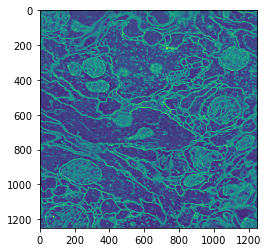

In [8]:
%matplotlib inline
plt.imshow(raw)